### Daily extremes via GEV fitting ###

Fitting GEV's to the time series of block minima/maxima from the model and observations.

Start with temperature over the UK, as we are happy with how this is processed.

Next look at 10m wind speed for the GB box.

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# import the temperature data
df_model_tas = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv"
)

# set up the djf winter years
djf_winter_years = np.arange(1, 11 + 1)

# set up a new dataframe to append to
df_model_tas_djf = pd.DataFrame()

# loop over the winter years
for i, wyear in enumerate(djf_winter_years):
    # set up the leads to extract
    leads = np.arange(31 + (i * 360), 31 + 90 + (i * 360))

    # extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_tas_djf = pd.concat([df_model_tas_djf, df_model_leads_this])

In [3]:
# subset model djf tas to the first winter
df_model_tas_djf_first = df_model_tas_djf[df_model_tas_djf["winter_year"] == 1]

# add the column for effective dec year to the model data
df_model_tas_djf_first["effective_dec_year"] = df_model_tas_djf_first["init_year"] + (df_model_tas_djf_first["winter_year"] - 1)

In [4]:
# import the observed data
# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to D, J, F
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([12, 1, 2])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [5]:
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None
    
# apply the effective dec year to the obs data
df_obs_tas["effective_dec_year"] = df_obs_tas.apply(
    lambda row: determine_effective_dec_year(row), axis=1
)

In [6]:
# Limit both datasets between 1960 and 2019
df_model_tas_djf_first = df_model_tas_djf_first[
    df_model_tas_djf_first["effective_dec_year"].between(1960, 2017)
]
df_obs_tas = df_obs_tas[df_obs_tas["effective_dec_year"].between(1960, 2017)]

# create new columns for data_c inh df_model_tas_djf_first
df_model_tas_djf_first["data_c"] = df_model_tas_djf_first["data"] - 273.15

In [7]:
df_obs_tas.tail()

,time,data,data_c,effective_dec_year
21239,2018-02-24,275.004977,1.854977,2017
21240,2018-02-25,274.473160,1.323160,2017
21241,2018-02-26,273.135263,-0.014737,2017
21242,2018-02-27,271.899134,-1.250866,2017
21243,2018-02-28,269.332502,-3.817498,2017


In [8]:
df_model_tas_djf_first.tail()

,init_year,member,lead,data,winter_year,effective_dec_year,data_c
2171375,2017,10,116,273.345904,1,2017,0.195904
2171376,2017,10,117,273.571250,1,2017,0.421250
2171377,2017,10,118,274.187873,1,2017,1.037873
2171378,2017,10,119,275.065096,1,2017,1.915096
2171379,2017,10,120,276.088821,1,2017,2.938821


In [9]:
# Now calculate the lowest temperature day for each effective dec year
df_obs_lowest_tas_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in df_obs_tas["effective_dec_year"].unique():
    # subset the data
    df_this = df_obs_tas[
        df_obs_tas["effective_dec_year"] == year
    ]

    # find the lowest wind day
    lowest_tas_day = df_this["data_c"].idxmin()

    # Create a new dataframe
    df_new = pd.DataFrame(
        {
            "effective_dec_year": [year],
            "time": [lowest_tas_day],
            "data": [df_this.loc[lowest_tas_day, "data_c"]],
        }
    )

    # Append to the new dataframe
    df_obs_lowest_tas_day_djf = pd.concat([df_obs_lowest_tas_day_djf, df_new])

In [10]:
# same for the model data
df_model_lowest_tas_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in df_model_tas_djf_first["effective_dec_year"].unique():
    for member in df_model_tas_djf_first["member"].unique():
        # subset the data
        df_this = df_model_tas_djf_first[
            (df_model_tas_djf_first["effective_dec_year"] == year)
            & (df_model_tas_djf_first["member"] == member)
        ]

        # find the lowest wind day
        lowest_tas_day = df_this["data_c"].idxmin()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "effective_dec_year": [year],
                "member": [member],
                "time": [lowest_tas_day],
                "data": [df_this.loc[lowest_tas_day, "data_c"]],
            }
        )

        # Append to the new dataframe
        df_model_lowest_tas_day_djf = pd.concat([df_model_lowest_tas_day_djf, df_new])

In [11]:
import scipy.stats as stats

# calculate the ensmean slope and intercept
dps_slopes = np.zeros(10)
dps_intercepts = np.zeros(10)

# Loop over the members
for i, member in enumerate(df_model_lowest_tas_day_djf["member"].unique()):
    # subset the data
    df_this = df_model_lowest_tas_day_djf[
        df_model_lowest_tas_day_djf["member"] == member
    ]

    # fit a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_this["effective_dec_year"],
        df_this["data"],
    )

    dps_slopes[i] = slope
    dps_intercepts[i] = intercept

# Calculate the ensemble mean slope and intercept
dps_slope = dps_slopes.mean()
dps_intercept = dps_intercepts.mean()

# create a new column in df_model_lowest_tas_day_djf for the data_dt
# which is the residual after the linear trend has been removed
df_model_lowest_tas_day_djf["data_dt"] = df_model_lowest_tas_day_djf["data"] - (dps_intercept + dps_slope * df_model_lowest_tas_day_djf["effective_dec_year"])
# df_model_lowest_tas_day_djf["data_tas_worst_wind_dt"] = df_model_lowest_tas_day_djf["data_tas_worst_wind"] - (dps_intercept + dps_slope * df_model_lowest_tas_day_djf["effective_dec_year"])

In [12]:
# Do the same for the obs data
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_obs_lowest_tas_day_djf["effective_dec_year"],
    df_obs_lowest_tas_day_djf["data"],
)

# create a new column in df_obs_lowest_tas_day_djf for the data_dt
# which is the residual after the linear trend has been removed
df_obs_lowest_tas_day_djf["data_dt"] = df_obs_lowest_tas_day_djf["data"] - (intercept + slope * df_obs_lowest_tas_day_djf["effective_dec_year"])

Text(0.5, 1.0, 'UK DJF block minima temperature 1960-2017')

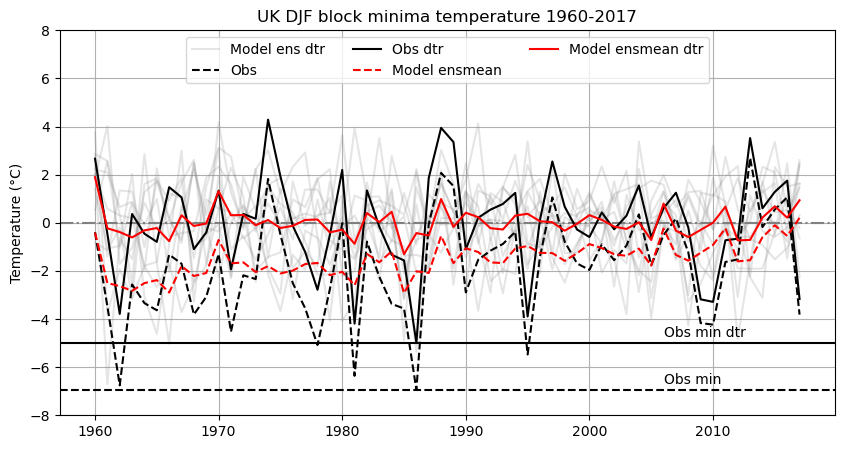

In [20]:
# set up a figure
# set up a figure with size 10x5
fig, ax = plt.subplots(figsize=(10, 5))

# include a horizontal line at 0
ax.axhline(0, color="grey", linestyle="-.")

# loop over the unique members
for i, member in enumerate(df_model_lowest_tas_day_djf["member"].unique()):
    # Select the data for this member
    df_member = df_model_lowest_tas_day_djf[df_model_lowest_tas_day_djf["member"] == member]

    # if i = 0
    if i == 0:
        # plot the data detrended in grey with a label
        ax.plot(df_member["effective_dec_year"], df_member["data_dt"], color="grey", alpha=0.2, label="Model ens dtr")
    else:
        # plot the data detrended in grey
        ax.plot(df_member["effective_dec_year"], df_member["data_dt"], color="grey", alpha=0.2)

# plot the observed time series (no dt) as a black dashed line
ax.plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data"], color="black", linestyle="--", label="Obs")

# plot the observed time series (dt) as a black solid line
ax.plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data_dt"], color="black", label="Obs dtr")

# include a dashed solid black line for the min value of the observed data (no dt)
ax.axhline(df_obs_lowest_tas_day_djf["data"].min(), color="black", linestyle="--")

# include a solid black line for the min value of the observed data (dt)
ax.axhline(df_obs_lowest_tas_day_djf["data_dt"].min(), color="black")

# include text on these lines
ax.text(
    2006,
    df_obs_lowest_tas_day_djf["data"].min() + 0.1,
    f"Obs min",
    color="black",
    verticalalignment="bottom",
)

ax.text(
    2006,
    df_obs_lowest_tas_day_djf["data_dt"].min() + 0.1,
    f"Obs min dtr",
    color="black",
    verticalalignment="bottom",
)

# ad a red line for the ensemble mean of the model data (no dt)
# mean over all of the members
ax.plot(df_model_lowest_tas_day_djf["effective_dec_year"].unique(), df_model_lowest_tas_day_djf.groupby("effective_dec_year")["data"].mean(), color="red", linestyle="--", label="Model ensmean")

# add a red line for the ensemble mean of the model data (dt)
# mean over all of the members
ax.plot(df_model_lowest_tas_day_djf["effective_dec_year"].unique(), df_model_lowest_tas_day_djf.groupby("effective_dec_year")["data_dt"].mean(), color="red", label="Model ensmean dtr")

# Do the same for the canari data
# # mean over all of the members
# ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data"].mean(), color="blue", linestyle="--", label="Canari no dtr")

# # add a red line for the ensemble mean of the model data (dt)
# # mean over all of the members
# ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data_dt"].mean(), color="blue", label="Canari dtr")

# Include gridlines
ax.grid(True)

# Include the y label with the degrees symbol
ax.set_ylabel("Temperature (°C)")

# include a legend
# in the top centre
ax.legend(loc="upper center", ncol=3)

# set the ylims
ax.set_ylim(-8, 8)

# Set up the title
ax.set_title("UK DJF block minima temperature 1960-2017")

Now process the GEV statistics for the detrended obs and model data.

In [32]:
from scipy.stats import genextreme as gev

# First fit a model to the observations
shape_obs, loc_obs, scale_obs = gev.fit(df_obs_lowest_tas_day_djf["data_dt"])

# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 10000

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_model_lowest_tas_day_djf["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_tas_day_djf["data_dt"].values)
    for y, year in enumerate(df_obs_lowest_tas_day_djf["effective_dec_year"].unique()):
        # Subset the data
        # df_model_this = df_model_lowest_tas_day_djf[
        #     df_model_lowest_tas_day_djf["effective_dec_year"] == year
        # ]

        # select a random year
        random_year = np.random.choice(df_model_lowest_tas_day_djf["effective_dec_year"].unique())

        # subset the data
        df_model_this = df_model_lowest_tas_day_djf[
            df_model_lowest_tas_day_djf["effective_dec_year"] == random_year
        ]

        # pick a random memebr
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # subset the data
        df_model_this = df_model_this[
            df_model_this["member"] == random_member
        ]

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data_dt"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

100%|██████████| 10000/10000 [04:48<00:00, 34.72it/s]


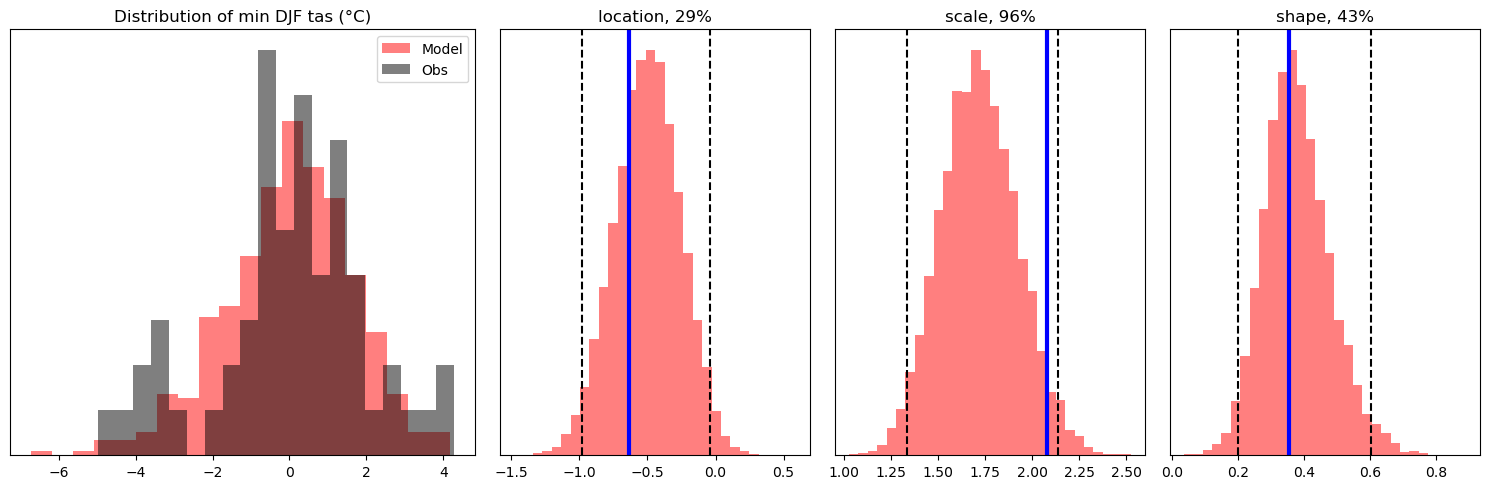

In [41]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_lowest_tas_day_djf["data_dt"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_lowest_tas_day_djf["data_dt"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of min DJF tas (°C)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc values in red
ax1.hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
ax2.hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs)

ax2.set_title("scale, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape values in red
ax3.hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs)

ax3.set_title("shape, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

### 10m wind speed ###

Now do the same for the 10m wind speed over the UK wind grid box.

In [43]:
# Set up the path to the obs data
obs_wind_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_UK_wind_box_1960-2018_daily_2025-02-26.csv"

# load the obs data
df_obs_wind = pd.read_csv(obs_wind_path)

In [46]:
# Set up a fname for the model data
fname = "HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_UK_wind_box_1960-2018_day.csv"

# Set up the directory in which the model data is stored
model_wind_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# form the complete path
model_wind_path = os.path.join(model_wind_dir, fname)

# if the path exists
if os.path.exists(model_wind_path):
    # load the model data
    df_model_wind = pd.read_csv(model_wind_path)
else:
    # Set up the years
    years = np.arange(1960, 2019)

    # Set up an empty dataframe
    df_model_wind = pd.DataFrame()

    # Loop over the years
    for year in years:
        for member in np.arange(1, 10 + 1):
            # Set up the fname
            fname = f"HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_UK_wind_box_{year}_{member}_day.csv"

            # Set up the path
            path = os.path.join(model_wind_dir, fname)

            # if the path exists
            if os.path.exists(path):
                # Load the data
                df_this = pd.read_csv(path)

                # Append to the main dataframe
                df_model_wind = pd.concat([df_model_wind, df_this])
            else:
                print(f"File does not exist for year {year} and month {member}")

    # Save the dataframe
    df_model_wind.to_csv(model_wind_path, index=False)

In [49]:
df_model_wind["data"].min()

np.float64(1.4768739)